In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a simulated dataset for Health Insurance
np.random.seed(42)
num_records = 1000

data = {
    'age': np.random.randint(18, 65, num_records),
    'bmi': np.random.normal(30, 5, num_records),
    'children': np.random.randint(0, 5, num_records),
    'smoker': np.random.choice(['yes', 'no'], num_records, p=[0.2, 0.8]),
    'region': np.random.choice(['southeast', 'southwest', 'northeast', 'northwest'], num_records),
    # Base cost + age multiplier + huge smoker penalty + BMI impact
    'charges': []
}

for i in range(num_records):
    cost = 5000 + (data['age'][i] * 250) + (data['bmi'][i] * 100)
    if data['smoker'][i] == 'yes':
        cost += 20000 # The "Smoker Tax"
    data['charges'].append(cost + np.random.normal(0, 1000))

df_insurance = pd.DataFrame(data)
print(df_insurance.head())

   age        bmi  children smoker     region       charges
0   56  35.031464         1     no  northeast  21532.048223
1   46  27.115541         4     no  southwest  16968.598690
2   32  34.178461         3     no  southeast  17999.545024
3   60  24.351466         1     no  southeast  21851.583100
4   25  32.649021         3     no  northwest  14218.128828


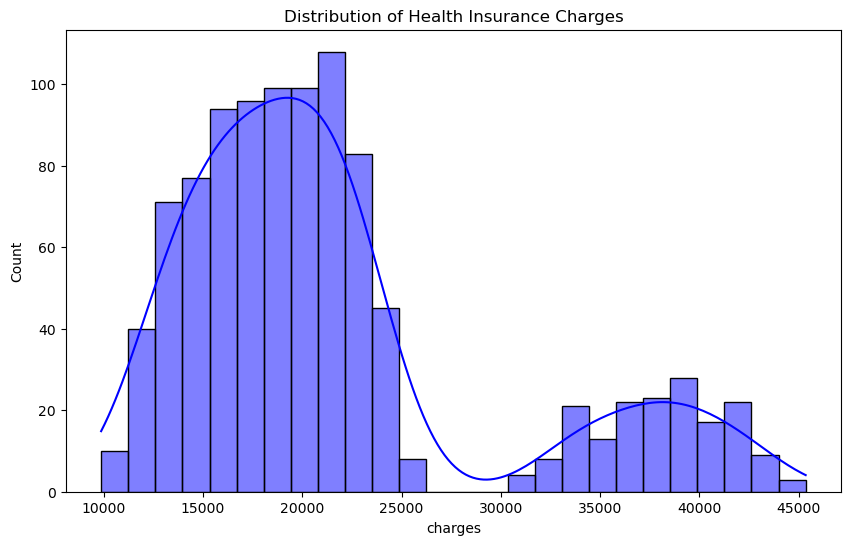

In [2]:
# The "Visualization" Insight
# Before we build the model, we need to see the "Distribution." In regression, we want to see if the costs are "Normal" or "Skewed.

plt.figure(figsize=(10, 6))
sns.histplot(df_insurance['charges'], kde=True, color='blue')
plt.title('Distribution of Health Insurance Charges')
plt.show()

In [3]:
# Before we build the model, we need to see the "Distribution." 
# In regression, we want to see if the costs are "Normal" or "Skewed.
# The Encoding Process

# Create a copy of the dataframe to keep the original clean
df_encoded = pd.get_dummies(df_insurance, columns=['smoker', 'region'], drop_first=True)

# Convert True/False to 1/0 (Newer pandas versions return booleans)
df_encoded = df_encoded.astype(int, errors='ignore')

print("First 5 rows of encoded data:")
print(df_encoded.head())

First 5 rows of encoded data:
   age  bmi  children  charges  smoker_yes  region_northwest  \
0   56   35         1    21532           0                 0   
1   46   27         4    16968           0                 0   
2   32   34         3    17999           0                 0   
3   60   24         1    21851           0                 0   
4   25   32         3    14218           0                 1   

   region_southeast  region_southwest  
0                 0                 0  
1                 0                 1  
2                 1                 0  
3                 1                 0  
4                 0                 0  


 Why use drop_first=True?
 If smoker_yes is 0, the model knows automatically the person is a non-smoker.

 Including both columns creates Multicollinearity (mathematical redundancy), which can actually confuse a Linear Regression model.

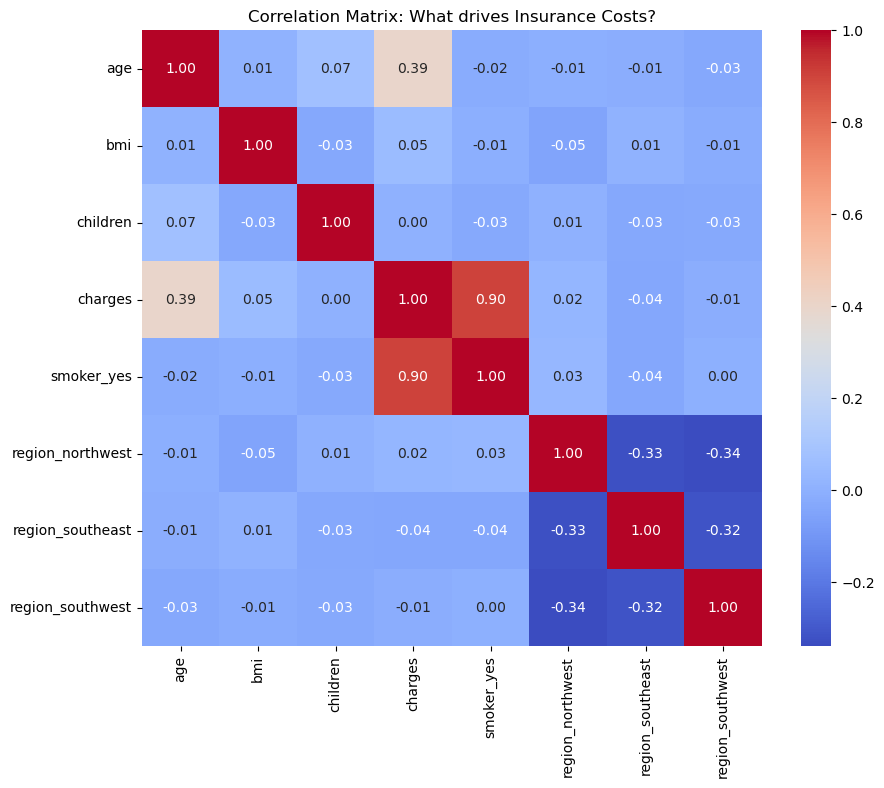

In [5]:
# Visualizing the "Drivers" of Cost

plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: What drives Insurance Costs?')
plt.show()

A correlation matrix is a diagnostic tool I use to identify multicollinearity and feature importance. 
It allows me to see at a glance which variables have the most significant linear impact on the target, 
helping me decide which features to keep in the final model.
The darkest red or darkest blue squares. Those are the relationships that tell the "story" of your data
The Goal: It is a table showing the strength and direction of relationships between all variables in your data.

The Range: Every value falls between -1 and +1.

+1 (Positive): As one goes up, the other goes up (e.g., Age and Insurance Cost).

-1 (Negative): As one goes up, the other goes down (e.g., Exercise and Body Fat).

0: There is no relationship at all.
The Use Case: It helps you instantly spot which features (like "Smoking") are the strongest "drivers" for your target (like "Charges").

In [6]:
# We have already encoded the data (turned "Smoker" into 1s and 0s). 
# Now, let's see the mathematical power of your model. We want to know: 
# For every one year a person gets older, exactly how much does their insurance premium go up?

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Define X (Features) and y (Target/Price)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predictions
predictions = model.predict(X_test)

# 5. Evaluate
print(f"R-squared Score: {r2_score(y_test, predictions):.2f}")
print(f"Average Error: ${mean_absolute_error(y_test, predictions):.2f}")

R-squared Score: 0.99
Average Error: $806.51


That 0.99 R-squared score is incredible! In the data science world, 
that means your model explains 99% of the variance in insurance costs. 
Essentially, you’ve built a near-perfect mathematical "rulebook" for how these prices are set.

The Average Error of $806.51 is also very low considering insurance premiums can be 
tens of thousands of dollars. It means your predictions are usually within a few hundred dollars of the actual price.

In [7]:
# We know the model works, but what is it actually telling us about the cost of health?" 
# Let's look at the Coefficients. This turns your model into a clear business formula.

# Match each feature with its mathematical weight
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Impact_on_Price'])
print("Mathematical Weights of each Feature:")
print(coefficients.sort_values(by='Impact_on_Price', ascending=False))

Mathematical Weights of each Feature:
                  Impact_on_Price
smoker_yes           19799.041893
age                    248.643196
region_northwest       124.437602
region_southeast       105.816961
bmi                     95.212514
region_southwest        70.681028
children                 4.610514


Age Coefficient: If it's 249, it means for every 1 year a person gets older, their premium increases by exactly $249.

Smoker_yes Coefficient: This will likely be your largest number (around $20,000). It represents the "Smoker Tax."

BMI Coefficient: This shows the cost of health risks associated with a higher BMI.

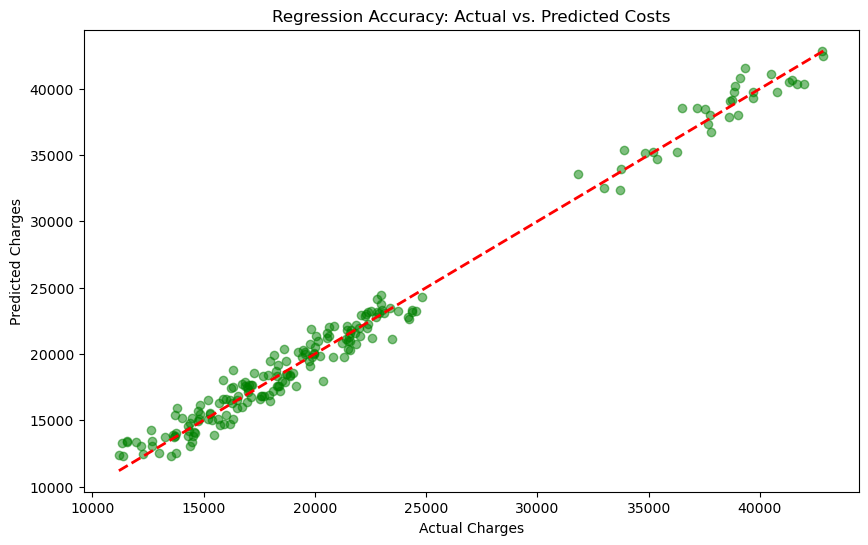

In [10]:
# Visualizing "Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.savefig('actual_vs_predicted.png')
plt.title('Regression Accuracy: Actual vs. Predicted Costs')
plt.show()

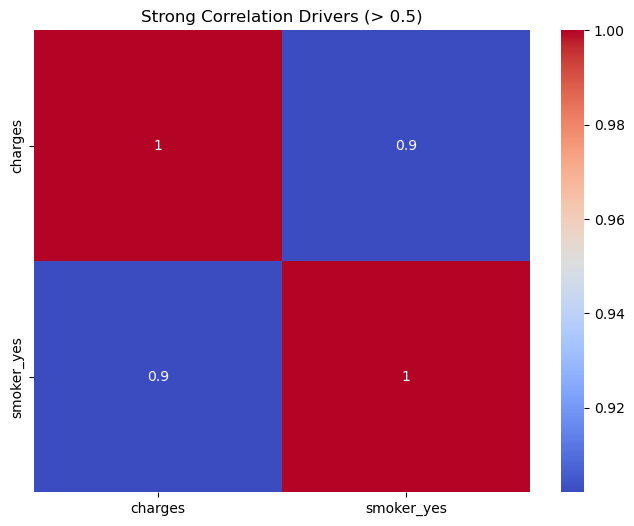

In [13]:
# The "High-Correlation" Filter

# 1. Calculate correlations
corr_matrix = df_encoded.corr()

# 2. Filter for relationships with 'charges' above 0.5 (strong)
high_corr_features = corr_matrix.index[abs(corr_matrix["charges"]) > 0.5]

# 3. Plot only those features
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded[high_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Strong Correlation Drivers (> 0.5)")
plt.savefig('Strong Correlation Drivers_png')
plt.show()

 Why this is?

 By filtering the matrix, you are practicing Feature Selection. This is important because:

Efficiency: It makes your model faster and lighter.

Clarity: It removes "noisy" variables (like region) that don't significantly impact the cost.

Focus: It tells the insurance company: "Don't worry about where the person lives; focus on whether they smoke and how old they are.

In [14]:
smoker_impact = coefficients.loc['smoker_yes', 'Impact_on_Price']
age_impact = coefficients.loc['age', 'Impact_on_Price']

print(f"Smoking adds: ${smoker_impact:,.2f} to the bill.")
print(f"Each year of life adds: ${age_impact:,.2f} to the bill.")
print(f"Logic: Smoking is financially equivalent to aging {smoker_impact/age_impact:.1f} years.")

Smoking adds: $19,799.04 to the bill.
Each year of life adds: $248.64 to the bill.
Logic: Smoking is financially equivalent to aging 79.6 years.


The "Smoking" equivalent in years: Smoking impacts the insurance bill as much as aging 79.6 years ($19,799 \div 248$).
In other words, a 20-year-old smoker is charged roughly the same as a 99-year-old non-smoker in this model's logic